Using Tensorflow backend


In [ ]:
# Load various imports 
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

Importing ICBHI_final_database from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mypath="/content/drive/MyDrive/Colab Notebooks/499/ICBHI_final_database/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [ ]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file) 

Reading Demographic info file

In [ ]:
path_demo ='/content/drive/MyDrive/Colab Notebooks/499/icbhi_other_files/demographic_info.txt'
col_names = ['patient_id', 'age', 'sex', 'adult_bmi', 'child_weight', 'child_height']

# Adult BMI (kg/m2)
# Child Weight (kg)
# Child Height (cm)

df_demo = pd.read_csv(path_demo, sep=" ", header=None, names=col_names)

df_demo.head(10)

,patient_id,age,sex,adult_bmi,child_weight,child_height
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0
5,106,73.00,F,21.00,NaN,NaN
6,107,75.00,F,33.70,NaN,NaN
7,108,3.00,M,NaN,NaN,NaN
8,109,84.00,F,33.53,NaN,NaN
9,110,75.00,M,25.21,NaN,NaN


Reading Patient diagnosis file

In [ ]:
path_pat= \
'/content/drive/MyDrive/Colab Notebooks/499/icbhi_other_files/patient_diagnosis.csv'

df_diag = pd.read_csv(path_pat, header=None, names=['patient_id', 'diagnosis'])

df_diag.head(10)

,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
5,106,COPD
6,107,COPD
7,108,LRTI
8,109,COPD
9,110,COPD


Reading Filename format

In [ ]:
path = \
'/content/drive/MyDrive/Colab Notebooks/499/icbhi_other_files/filename_format.txt.txt'

data = open(path, 'r').read()

data

'Elements contained in the filenames:\n\nPatient number (101,102,...,226)\nRecording index\nChest location (Trachea (Tc), {Anterior (A), Posterior (P), Lateral (L)}{left (l), right (r)})\nAcquisition mode (sequential/single channel (sc), simultaneous/multichannel (mc))\nRecording equipment (AKG C417L Microphone, 3M Littmann Classic II SE Stethoscope, 3M Litmmann 3200 Electronic Stethoscope, WelchAllyn Meditron Master Elite Electronic Stethoscope)'

Reading an annotated txt file of its corresponding audio file

In [ ]:
path_dis = \
'/content/drive/MyDrive/Colab Notebooks/499/ICBHI_final_database/101_1b1_Al_sc_Meditron.txt'

col_names = ['Beginning_of_respiratory_cycle', 'End_of_respiratory_cycle', 'Presence/absence_of_crackles', 'Presence/absence_of_wheezes']

# Respiratory cycle column values are in 'seconds'.
# Presence = 1
# Absence = 0

df_annot = pd.read_csv(path_dis, sep="\t", header=None, names=col_names)

df_annot.head(10)

,Beginning_of_respiratory_cycle,End_of_respiratory_cycle,Presence/absence_of_crackles,Presence/absence_of_wheezes
0,0.036,0.579,0,0
1,0.579,2.450,0,0
2,2.450,3.893,0,0
3,3.893,5.793,0,0
4,5.793,7.521,0,0
5,7.521,9.279,0,0
6,9.279,11.150,0,0
7,11.150,13.036,0,0
8,13.036,14.721,0,0
9,14.721,16.707,0,0


In [ ]:
path_spec = \
'/content/drive/MyDrive/Colab Notebooks/499/ICBHI_final_database/154_2b4_Al_mc_AKGC417L.txt'

col_names = ['Beginning_of_respiratory_cycle', 'End_of_respiratory_cycle', 'Presence/absence_of_crackles', 'Presence/absence_of_wheezes']

# Respiratory cycle column values are in 'seconds'.
# Presence = 1
# Absence = 0

df_annot = pd.read_csv(path_spec, sep="\t", header=None, names=col_names)

df_annot.head(20)

,Beginning_of_respiratory_cycle,End_of_respiratory_cycle,Presence/absence_of_crackles,Presence/absence_of_wheezes
0,1.330,3.804,0,0
1,3.804,6.396,0,0
2,6.396,8.938,1,0
3,8.938,11.580,1,0
4,11.580,14.072,1,0
5,14.072,17.049,1,0
6,17.049,19.490,1,0


We see that this recording contains 7 respiration cycles. We also see that crackles are present on 5 of the 7 cycles.

In [ ]:
# Install the pysoundfile library
! pip install pysoundfile

In [ ]:
import soundfile as sf

# Define helper functions

# Load a .wav file. 
# These are 24 bit files. The PySoundFile library is able to read 24 bit files.
# https://pysoundfile.readthedocs.io/en/0.9.0/

def get_wav_info(wav_file):
    data, rate = sf.read(wav_file)
    return data, rate

# source: Andrew Ng Deep Learning Specialization, Course 5
def graph_spectrogram(wav_file):
    data, rate = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

In [ ]:
path = \
'/content/drive/MyDrive/Colab Notebooks/499/ICBHI_final_database/154_2b4_Al_mc_AKGC417L.wav'

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


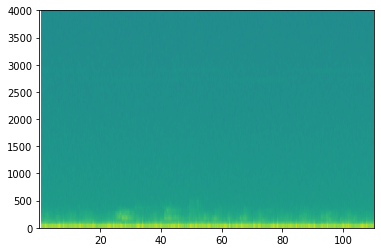

In [ ]:
x = graph_spectrogram(path)

Time is on the x axis and Frequencies are on the y axis. The intensity of the different colours shows the amount of energy i.e. how loud the sound is, at different frequencies, at different times.

**Part B: Plotting the MFCC**

In [ ]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [ ]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [ ]:
p_diag = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/499/icbhi_other_files/patient_diagnosis.csv",header=None) # patient diagnosis file

In [ ]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [ ]:
 features = []

 # Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

Finished feature extraction from  920  files


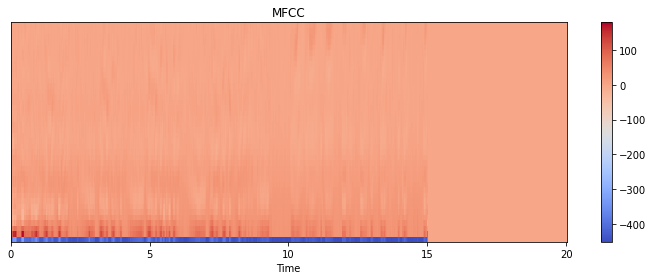

In [ ]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [ ]:
features = np.array(features) # convert to numpy array

In [ ]:
features.shape

(920, 40, 862)

In [ ]:
# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [ ]:
# print class counts
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


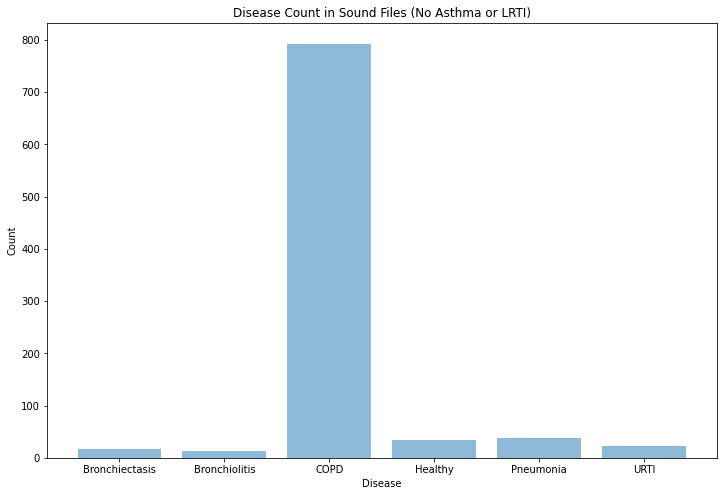

In [ ]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [ ]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels) 

In [ ]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1)) 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

#function
def train_test_rmse(x,y):
    x = Iris_data[x]
    y = Iris_data[y]
    x_train, x_test, y_train, y_test = train_test_split(x, y, features1, oh_labels, stratify=oh_labels, test_size = 0.2,random_state=42)
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)
    y_pred = linreg.predict(x_test)
    print(accuracy_score(y_test, y_pred))  # or you can save it in variable and return it 
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, test_size = 0.2,random_state=42)

**Part C: Creating CNN model**

In [ ]:
num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [ ]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 861, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 430, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 430, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 429, 32)       2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 214, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 214, 32)        0

In [ ]:
# train model
num_epochs = 250
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/250
6/6 [==============================] - ETA: 0s - loss: 5.9443 - accuracy: 0.7367
Epoch 00001: val_accuracy improved from -inf to 0.11413, saving model to mymodel2_01.h5
6/6 [==============================] - 5s 435ms/step - loss: 5.9443 - accuracy: 0.7367 - val_loss: 3.6568 - val_accuracy: 0.1141
Epoch 2/250
6/6 [==============================] - ETA: 0s - loss: 5.4902 - accuracy: 0.7312
Epoch 00002: val_accuracy improved from 0.11413 to 0.86413, saving model to mymodel2_02.h5
6/6 [==============================] - 1s 137ms/step - loss: 5.4902 - accuracy: 0.7312 - val_loss: 2.1206 - val_accuracy: 0.8641
Epoch 3/250
6/6 [==============================] - ETA: 0s - loss: 3.7322 - accuracy: 0.7940
Epoch 00003: val_accuracy did not improve from 0.86413
6/6 [==============================] - 1s 124ms/step - loss: 3.7322 - accuracy: 0.7940 - val_loss: 1.7769 - val_accuracy: 0.7554
Epoch 4/250
6/6 [==============================] - ETA: 0s - loss: 2.5005 - accuracy: 0.8608
Epoch 0

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9304229021072388
Testing Accuracy:  0.85326087474823


In [ ]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=6 # number of classes

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

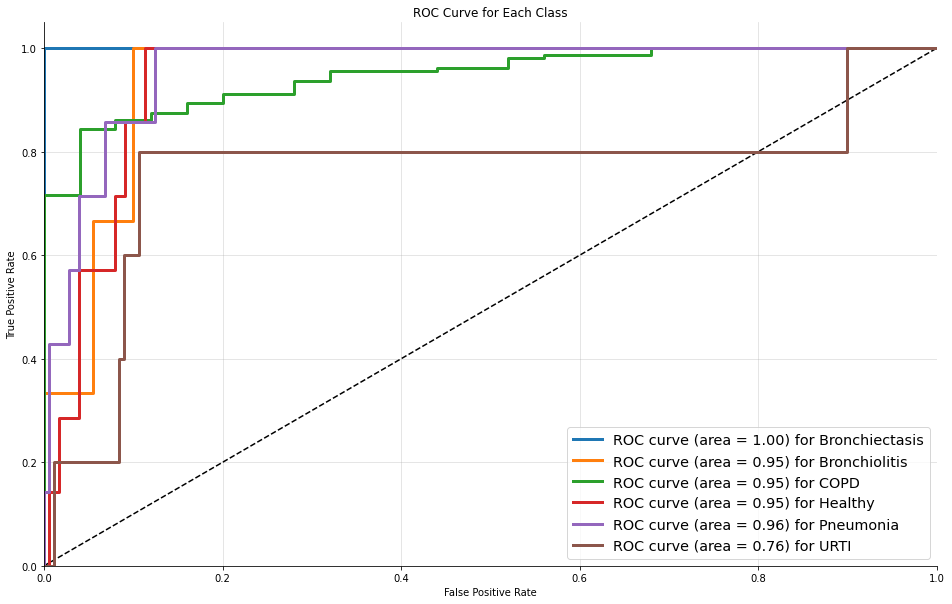

In [ ]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       1.00      0.67      0.80         3
 Bronchiolitis       0.12      0.33      0.18         3
          COPD       0.96      0.94      0.95       159
       Healthy       0.00      0.00      0.00         7
     Pneumonia       0.44      0.57      0.50         7
          URTI       0.12      0.20      0.15         5

      accuracy                           0.85       184
     macro avg       0.44      0.45      0.43       184
  weighted avg       0.86      0.85      0.86       184



In [ ]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[  2   1   0   0   0   0]
 [  0   1   0   0   1   1]
 [  0   2 149   1   3   4]
 [  0   2   3   0   0   2]
 [  0   0   3   0   4   0]
 [  0   2   1   0   1   1]]


#**VGG16**

#### **VGG16 Implementation:**

In [ ]:
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

#### **Model Construction:**

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(num_rows, num_columns, num_channels),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [ ]:
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=6, activation="softmax")) #6 for 6 classes

In [ ]:
import tensorflow as tf

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001)
#model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])tf.
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 40, 862, 64)       640       
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 862, 64)       36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 431, 64)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 431, 128)      73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 431, 128)      147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 215, 128)     0         
 2D)                                                  

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#hist = model.fit_generator(steps_per_epoch=100,generator=traindata, validation_data= testdata, validation_steps=10,epochs=100,callbacks=[checkpoint,early])

hist = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=100,
          validation_data=(x_test, y_test),steps_per_epoch=100,validation_steps=10, callbacks=[checkpoint,early])

Epoch 1/100
100/100 [==============================] - 309s 3s/step - loss: 4.9142 - accuracy: 0.8562 - val_loss: 0.5310 - val_accuracy: 0.8641
Epoch 2/100
100/100 [==============================] - 237s 2s/step - loss: 0.4254 - accuracy: 0.8642
Epoch 3/100
100/100 [==============================] - 238s 2s/step - loss: 0.3138 - accuracy: 0.8787
Epoch 4/100
100/100 [==============================] - 241s 2s/step - loss: 0.1640 - accuracy: 0.9404
Epoch 5/100
100/100 [==============================] - 236s 2s/step - loss: 0.0187 - accuracy: 0.9949
Epoch 6/100
100/100 [==============================] - 236s 2s/step - loss: 3.9290e-06 - accuracy: 1.0000
Epoch 7/100
100/100 [==============================] - 0s 618us/step - loss: 3.9290e-06 - accuracy: 1.0000
